In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

# CRF 층 설치하기

**1) CRF 층을 손쉽게 사용하기 위한 keras-crf를 설치**

In [ ]:
!pip install keras-crf==0.3.0

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
# 모델 평가
!pip install seqeval

     |████████████████████████████████| 43 kB 828 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=487266b3ca3a8ba64c2e4741beffd6bbf3a7f3836117a70c4fa7f4ce54510c12
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
!pip list | grep keras-crf

keras-crf                     0.3.0


# 또다른 개체명 인식 데이터에 대한 이해와 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

**1) Annotated Corpus 데이터 다운로드**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="ner_dataset.csv")

('ner_dataset.csv', <http.client.HTTPMessage at 0x7f5243b2f950>)

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

**2) 샘플 5개 출력**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **t번째 문장을 단어 토큰화 후 각 행으로 나눠놓은 데이터이기 때문에**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **Sentence: t부터 Null 값이 나오다가 Sentence: t+1이 나오기 전까지의 모든 행은 기존에 하나의 문장임**

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


**3) 데이터의 행의 개수를 확인**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **이는 문장 1개를 다수의 행들로 나누어 놓은 것이므로 다시 1개의 행으로 병합하는 작업을 하면 최종 샘플의 수는 이보다 적음**

In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


**4) 결측값 유무 출력**

In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

**5) 전체 데이터에서 중복을 허용하지 않고 유일한 값의 개수를 확인**

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


**6) 17개의 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **아무런 태깅도 의미하지 않는 O가 가장 많은 개수를 차지함**

In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


**7) Null을 제거하도록 함**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **t번째 문장에 속하면서 Null 값을 가진 샘플들은 전부 첫 번째 열에 Sentence: t의 값이 들어가게 됨**

In [ ]:
data = data.fillna(method="ffill")

In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


**8) 모든 단어를 소문자화하여 단어의 개수를 줄이기**

In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


**9) 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍으로 묶기**

In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


**10) zip() 함수를 이용해서 단어 부분과 개체명 태깅 정보 부분을 분리시켜 sentences와 ner_tags에 저장**

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**11) 전체 데이터의 길이 분포 확인**

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


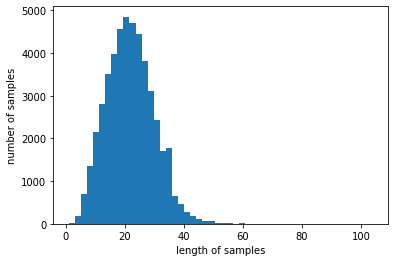

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**12) 케라스 토크나이저를 통해 문장 데이터와 레이블에 해당되는 개체명 태깅 정보에 대해 정수 인코딩 진행**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
        **src_tokenizer를 만들 때 인자로 oov_token='OOV'를 선택했으므로 인덱스1에 단어 'OOV'가 할당됨**

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


**13) 정수 인코딩을 수행하여 문장 데이터는 X_data에, 개체명 태깅 데이터는 y_data에 저장**

In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


**14) 인덱스로부터 단어를 리턴하는 index_to_word와 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner을 생성**

In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


**15) index_to_word를 통해 정수 인코딩 된 첫 번째 샘플을 다시 디코딩하여 변환해보기**

In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


**16) 대부분의 샘플은 길이가 40~60에 분포하므로 X_train과 y_train의 모든 길이를 임의로 70으로 맞추기**

In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(47959, 70)
(47959, 70)


**17) 훈련 데이터와 테스트 데이터를 8:2 비율로 분리**

In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

**18) 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행**

In [ ]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


# BiLSTM-CRF를 이용한 개체명 인식

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

**1) 마지막 층에 CRF층을 추가하기 위하여 함수형 API를 사용**<br>
**2) 임베딩 벡터의 차원은 128, LSTM의 은닉 상태의 크기는 64로 지정**<br>
**3) 다 대 다 문제이므로 LSTM의 return_squences의 값은 True로 지정하고 양방향 사용을 위해 Bidirectional() 사용**<br>
**4) LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용해야 하므로 출력층에 TimeDistributed() 사용**<br>
**5) 모든 시점에 대해서 개체명 레이블의 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **최종 출력층을 CRF층으로 하여 CRF층에 분류해야 하는 선택지 개수를 의미하는 tag_size를 전달**<br>
**6) EarlyStopping을 사용해 검증 데이터 손실이 증가하면 과적합 징후이므로 4회 증가하면 학습을 조기 종료하도록 함**<br>
**7) ModelCheckpoint를 사용해 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장함**

In [ ]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 70, 128)      4072832     ['sequence_input[0][0]']         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 70, 128)     98816       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 time_distributed_3 (TimeDistri  (None, 70, 128)     0           ['bidirectional_2[0][0]']

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

**8) validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리하여 사용해 훈련이 적절히 되고 있는지 확인**<br>
**9) 배치 크기는 128로 하여 15번의 에포크를 수행**

In [ ]:
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9204 - loss: 28.7448
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.96133, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 46s 147ms/step - decode_sequence_accuracy: 0.9204 - loss: 28.6784 - val_decode_sequence_accuracy: 0.9613 - val_loss: 10.0355
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9702 - loss: 6.8184
Epoch 00002: val_decode_sequence_accuracy improved from 0.96133 to 0.97886, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 39s 146ms/step - decode_sequence_accuracy: 0.9702 - loss: 6.8108 - val_decode_sequence_accuracy: 0.9789 - val_loss: 5.2493
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9817 - loss: 3.9034
Epoch 00003: val_decode_sequence_accuracy improved from 0.97886 to 0.98280, saving model to bilstm_crf/cp.ckpt

**10) 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러오기**

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

**11) 테스트 데이터의 임의의 인덱스 13번 샘플에 대해서 실제값과 예측값을 비교**

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


**12) 테스트 데이터에 대해서 성능을 측정하기 위해 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻기**

In [ ]:
y_predicted = model.predict(X_test)[0]

**13) 확률 벡터가 아닌 정수 시퀀스를 입력으로 받아서 태깅 정보 시퀀스를 리턴하는 sequences_to_tag_for_crf 함수 생성**

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
def sequences_to_tag_for_crf(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            # pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = pred
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.90      0.17      0.29        52
         geo       0.83      0.84      0.84      7620
         gpe       0.95      0.93      0.94      3145
         nat       0.00      0.00      0.00        37
         org       0.64      0.58      0.61      4033
         per       0.76      0.70      0.73      3545
         tim       0.86      0.83      0.85      4067

   micro avg       0.81      0.78      0.80     22562
   macro avg       0.62      0.51      0.53     22562
weighted avg       0.81      0.78      0.79     22562



**14) sequences_to_tag_for_crf를 사용해 예측값과 레이블에 해당하는 y_test를 태깅 정보 시퀀스로 변환하여 f1-score 계산**

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 79.6%
